In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/r7gCrm5XkuYzMWz9vdZnsEweu80OIQt_j5brprB_jxU
API Key valid
Saved API Key successfully!


In [ ]:
# Downloading the Dataset
!rm -rf data
!mkdir data
!mkdir data/model
%aicrowd ds dl -c foodch -o data

train_images.zip:   0%|          | 0.00/754M [00:00<?, ?B/s]

test_images.zip:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/253k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

In [ ]:
!unzip /content/data/train_images.zip -d data/ > /dev/null
!unzip /content/data/test_images.zip -d data/ > /dev/null
!rm /content/data/test_images.zip
!rm /content/data/train_images.zip

In [ ]:
from os import listdir
from matplotlib import image
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Importing the Dataset
train_df = pd.read_csv("/content/data/train.csv")

# Making the path column
train_df["path"] = "/content/data/train_images/" + train_df["ImageId"]

# Making a dictionary for mapping class names to labels
classes = train_df["ClassName"].unique()
index = [ i for i in range(len(classes))]

class_map = dict(zip(index, classes))
class_reverse_map = dict(zip(classes, index))

# Transforming the labels
train_df["ClassName"] = train_df["ClassName"].map(lambda x : class_reverse_map[x])
train_df = train_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
train_df.head()

,ImageId,ClassName,path
0,15f2da0718.jpg,8,/content/data/train_images/15f2da0718.jpg
1,cc0f1ea580.jpg,58,/content/data/train_images/cc0f1ea580.jpg
2,11291b3de0.jpg,0,/content/data/train_images/11291b3de0.jpg
3,0d9c13102f.jpg,14,/content/data/train_images/0d9c13102f.jpg
4,8bb0efefa5.jpg,19,/content/data/train_images/8bb0efefa5.jpg


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
)

In [ ]:
train_set = train_generator.flow_from_dataframe(
    dataframe=train_df,
    target_size=(224, 224),
    x_col='path',
    y_col='ClassName',
    class_mode="raw",
    batch_size=64,
    subset='training',
    shuffle=False
)

val_set = train_generator.flow_from_dataframe(
    dataframe=train_df,
    target_size=(244, 244),
    x_col='path',
    y_col='ClassName',
    class_mode='raw',
    batch_size=64,
    subset='validation',
    shuffle=False
)


Found 8391 validated image filenames.
Found 932 validated image filenames.


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/data/model',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/distill_bit_r50x1_224_feature_extraction/1", trainable=False)

model = tf.keras.Sequential(
    [
        hub_layer,
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(61, activation="softmax"),
    ]
)

model.build([None, 224, 224, 3])

model.compile(optimizer = tf.keras.optimizers.Adam(), 
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'] 
          )

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 2048)              23500352  
                                                                 
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 61)                7869      
                                                                 
Total params: 23,787,005
Trainable params: 286,653
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
 history = model.fit(train_set, validation_data = val_set, epochs = 10, callbacks=[model_checkpoint_callback])

Epoch 1/10
132/132 [==============================] - 244s 2s/step - loss: 2.4536 - accuracy: 0.3945 - val_loss: 1.8351 - val_accuracy: 0.4946
Epoch 2/10
132/132 [==============================] - 220s 2s/step - loss: 1.5182 - accuracy: 0.5657 - val_loss: 1.5581 - val_accuracy: 0.5676
Epoch 3/10
132/132 [==============================] - 225s 2s/step - loss: 1.3072 - accuracy: 0.6151 - val_loss: 1.4642 - val_accuracy: 0.5751
Epoch 4/10
132/132 [==============================] - 219s 2s/step - loss: 1.1812 - accuracy: 0.6426 - val_loss: 1.4986 - val_accuracy: 0.5697
Epoch 5/10
132/132 [==============================] - 220s 2s/step - loss: 1.0871 - accuracy: 0.6599 - val_loss: 1.4121 - val_accuracy: 0.5880
Epoch 6/10
132/132 [==============================] - 220s 2s/step - loss: 1.0039 - accuracy: 0.6874 - val_loss: 1.4434 - val_accuracy: 0.5773
Epoch 7/10
132/132 [==============================] - 219s 2s/step - loss: 0.9290 - accuracy: 0.7052 - val_loss: 1.4712 - val_accuracy: 0.5891

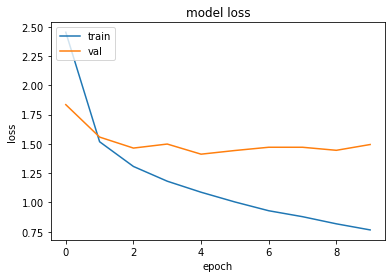

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_df = pd.read_csv("/content/data/test.csv")
test_df["path"] = "/content/data/test_images/" + test_df["ImageId"]
test_df.head()

,ImageId,path
0,90e63a2fde.jpg,/content/data/test_images/90e63a2fde.jpg
1,a554d1ca8d.jpg,/content/data/test_images/a554d1ca8d.jpg
2,48317e8ee8.jpg,/content/data/test_images/48317e8ee8.jpg
3,79528df667.jpg,/content/data/test_images/79528df667.jpg
4,6d2f2f63f5.jpg,/content/data/test_images/6d2f2f63f5.jpg


In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_set = train_generator.flow_from_dataframe(
    dataframe=test_df,
    target_size=(224, 224),
    x_col='path',
    y_col=None,
    class_mode=None,
    color_mode='rgb',
    shuffle=False
)

Found 484 validated image filenames.


In [ ]:
y_pred = model.predict(test_set)

In [ ]:
values = list(np.squeeze(y_pred))

In [ ]:
for i in range(len(values)):
  values[i] = class_map[np.argmax(values[i])]

In [ ]:
test_df["ClassName"] = values
test_df.head()

,ImageId,path,ClassName
0,90e63a2fde.jpg,/content/data/test_images/90e63a2fde.jpg,water
1,a554d1ca8d.jpg,/content/data/test_images/a554d1ca8d.jpg,water-mineral
2,48317e8ee8.jpg,/content/data/test_images/48317e8ee8.jpg,coffee-with-caffeine
3,79528df667.jpg,/content/data/test_images/79528df667.jpg,hard-cheese
4,6d2f2f63f5.jpg,/content/data/test_images/6d2f2f63f5.jpg,bread-white


In [ ]:
test_df = test_df.drop(columns=['ImageId', 'path'])
test_df.head()

,ClassName
0,water
1,water-mineral
2,coffee-with-caffeine
3,hard-cheese
4,bread-white


In [ ]:
test_df.to_csv('submission.csv',index=False)